## Georgia Bridge Condition Analysis

## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Georgia Bridge Condition Analysis](#1_Georgia_Bridge_Condition_Analysis)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Introduction](#1.2_Introduction)
  * [1.3 Objectives](#1.3_Objectives)
  * [1.4 Load The Ski Resort Data](#1.4_Load_The_Ski_Resort_Data)
  * [1.5 Explore The Data](#1.5_Explore_The_Data)

## 1.2 Introduction<a id='1.2_Introduction'></a>

## 1.3 Objectives<a id='1.3_Objectives'></a>

In [67]:
import pandas, matplotlib.pyplot
import seaborn
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import fuzz
from thefuzz import process
from datetime import datetime
import numpy as np
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import prince
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

#import dython
import mpld3

from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

In [42]:
def convert(
    data,
    to=["array", "list", "dataframe"],
    copy: bool = True,
):
    converted = None
    if to == "array":
        if isinstance(data, np.ndarray):
            converted = data.copy() if copy else data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.values()  # type: ignore
    elif to == "list":
        if isinstance(data, list):
            converted = data.copy() if copy else data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == "dataframe":
        if isinstance(data, pd.DataFrame):
            converted = data.copy(deep=True) if copy else data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError(
            "cannot handle data conversion of type: {} to {}".format(
                type(data), to
            )
        )
    else:
        return converted  # type: ignore

def identify_columns_with_na(dataset):
    """
    Return columns names having NA values, sorted in descending order by their number of NAs

    Parameters:
    -----------
    dataset : NumPy ndarray / Pandas DataFrame

    Returns:
    --------
    A DataFrame of two columns (['column', 'na_count']), consisting of only the names
    of columns with NA values, sorted by their number of NA values.

    Example:
    --------
    >>> df = pd.DataFrame({'col1': ['a', np.nan, 'a', 'a'], 'col2': [3, np.nan, 2, np.nan], 'col3': [1., 2., 3., 4.]})
    >>> identify_columns_with_na(df)
      column  na_count
    1   col2         2
    0   col1         1
    """
    df: pd.DataFrame = convert(dataset, "dataframe")  # type: ignore
    na_count = [sum(df[cc].isnull()) for cc in df.columns]
    return (
        pd.DataFrame({"column": df.columns, "na_count": na_count})
        .query("na_count > 0")
        .sort_values("na_count", ascending=False)
    )




In [2]:
#Testing size of dataset with different dtypes

#bridges = pd.read_csv('../Data/Last_Year_All_Field_Bridges.csv',sep=',',header='infer', low_memory=True)

#Load Georgia data 

bridges = pd.read_csv('../Data/Last_Year_All_Field_Bridges.csv',sep=',',header='infer',dtype='category')


In [3]:
#Displaying data types of dataset

pd.set_option('display.max_rows',20)
bridges.dtypes

1 - State Code                              category
1 - State Name                              category
8 - Structure Number                        category
22 - Owner Agency                           category
3 - County Code                             category
                                              ...   
Total Precipitation                         category
Metropolitan Planning Organization (MPO)    category
U.S. Congressional District                 category
State Senate District                       category
State House District                        category
Length: 143, dtype: object

In [4]:
#Checking for duplicated values across the dataset

bridges.duplicated().sum()

0

In [5]:
#Assesing percentage of missing values by features

missing = pd.concat([bridges.isnull().sum(), 100*bridges.isnull().sum()/bridges.shape[0]], axis=1)
missing.columns = ['Count', '%']
missing.sort_values(by='%', ascending=False, inplace=True)

missing[missing['%']>10]

,Count,%
Number of Freeze-Thaw Cycles,15034,100.000000
Number of Snowfall Days,15034,100.000000
98A - Neighboring State Name,14982,99.654117
99 - Border Bridge Structure Number,14982,99.654117
98B - Neighboring State Percent Responsibility,14982,99.654117
93A - Fracture Critical Detail Date,14953,99.461221
103 - Temporary Structure Designation Code,14923,99.261674
93C - Other Special Inspection Date,14774,98.270587
97 - Year of Improvement Cost Estimate,14001,93.128908
111 - Pier Abutment Protection Code,13597,90.441666


In [6]:
#Assesing percentage of missing values by features

missing = pd.concat([bridges.isnull().sum(), 100*bridges.isnull().sum()/bridges.shape[0]], axis=1)
missing.columns = ['Count', '%']
missing.sort_values(by='%', ascending=False, inplace=True)

missing[missing['%']>10]

,Count,%
Number of Freeze-Thaw Cycles,15034,100.000000
Number of Snowfall Days,15034,100.000000
98A - Neighboring State Name,14982,99.654117
99 - Border Bridge Structure Number,14982,99.654117
98B - Neighboring State Percent Responsibility,14982,99.654117
93A - Fracture Critical Detail Date,14953,99.461221
103 - Temporary Structure Designation Code,14923,99.261674
93C - Other Special Inspection Date,14774,98.270587
97 - Year of Improvement Cost Estimate,14001,93.128908
111 - Pier Abutment Protection Code,13597,90.441666


In [7]:
missing[missing['%']>10]

#Apply PCA and check for correlation

#OptionA
#Check imbalance data
#SMOTE : To generate syntetic data
#Only for training

#OptionB
#Drop features with missing values > 10%

#OptionC
#Rough correlation 

,Count,%
Number of Freeze-Thaw Cycles,15034,100.000000
Number of Snowfall Days,15034,100.000000
98A - Neighboring State Name,14982,99.654117
99 - Border Bridge Structure Number,14982,99.654117
98B - Neighboring State Percent Responsibility,14982,99.654117
93A - Fracture Critical Detail Date,14953,99.461221
103 - Temporary Structure Designation Code,14923,99.261674
93C - Other Special Inspection Date,14774,98.270587
97 - Year of Improvement Cost Estimate,14001,93.128908
111 - Pier Abutment Protection Code,13597,90.441666


In [8]:
#Assigning dropped_columns variables which contains more than 10% of missing values.

dropped_columns = (missing.index[missing['%']>10])

dropped_columns

Index(['Number of Freeze-Thaw Cycles', 'Number of Snowfall Days',
       '98A - Neighboring State Name', '99 - Border Bridge Structure Number',
       '98B - Neighboring State Percent Responsibility',
       '93A - Fracture Critical Detail Date',
       '103 - Temporary Structure Designation Code',
       '93C - Other Special Inspection Date',
       '97 - Year of Improvement Cost Estimate',
       '111 - Pier Abutment Protection Code',
       '93B - Underwater Inspection Date', '106 - Year Reconstructed',
       '75B - Work Done By', '75A - Type of Work Proposed',
       'Metropolitan Planning Organization (MPO)',
       '13A - LRS Inventory Route'],
      dtype='object')

In [9]:
n_bridges = bridges.drop(dropped_columns, axis=1)

print(f'Dataset shape before columns dropped: {bridges.shape}')
print(f'New dataset shape after columns dropped: {n_bridges.shape}')
print(f'Columns dropped: {bridges.shape[1] - n_bridges.shape[1]}')

Dataset shape before columns dropped: (15034, 143)
New dataset shape after columns dropped: (15034, 127)
Columns dropped: 16


In [10]:
#Check for columns with repeated observations

repeated_values = []
for name in n_bridges.columns:
    repeated_values.append(n_bridges.duplicated(subset=[name]).sum())

repeated_values_df = pd.DataFrame(data = repeated_values, index = n_bridges.columns)                                               
repeated_values_df.columns = ['Count']
repeated_values_df['%'] = repeated_values_df['Count']*100/n_bridges.shape[0]
repeated_values_df.sort_values(by='Count', ascending=False, inplace=True)

repeated_values_df[repeated_values_df['%'] > 99.99]    

n_bridges.drop('1 - State Code', axis =1, inplace = True)

print(f'New dataset shape after column dropped: {n_bridges.shape}')


New dataset shape after column dropped: (15034, 126)


In [11]:
pd.set_option('display.max_columns', None)
n_bridges.head(2)

,1 - State Name,8 - Structure Number,22 - Owner Agency,3 - County Code,3 - County Name,4 - Place Code,City - InfoBridge Place Code,City - InfoBridge Place Name,27 - Year Built,29 - Average Daily Traffic,43A - Main Span Material,43B - Main Span Design,45 - Number of Spans in Main Unit,49 - Structure Length (ft.),6A - Features Intersected,7 - Facility Carried By Structure,CAT10 - Bridge Condition,Bridge Age (yr),CAT29 - Deck Area (sq. ft.),2 - Highway Agency District,9 - Location,11 - Mile Point (miles),16 - Latitude (decimal),17 - Longitude (decimal),21 - Maintenance Responsibility,37 - Historical Significance Code,101 - Parallel Structure Designation Code,44A - Approach Spans Material,44B - Approach Spans Design,46 - Number of Approach Spans,107 - Deck Structure Type Code,108A - Wearing Surface Type Code,108B - Membrane Type Code,108C - Deck Protection Code,10 - Inventory Route - Minimum Vertical Clearance (ft.),32 - Approach Roadway Width (ft.),33 - Bridge Median Code,34 - Skew Angle (degrees),35 - Structure Flared,38 - Navigation Control Code,39 - Navigation Vertical Clearance (ft.),40 - Navigation Horizontal Clearance (ft.),47 - Inventory Route Total Horizontal Clearance (ft.),48 - Length of Maximum Span (ft.),50A - Left Curb/Sidewalk Width (ft.),50B - Right Curb/Sidewalk Width (ft.),51 - Bridge Roadway Width Curb to Curb (ft.),52 - Deck Width - Out to Out (ft.),53 - Minimum Vertical Clearance Over Bridge Roadway (ft.),54B - Minimum Vertical Underclearance (ft.),55B - Minimum Lateral Underclearance on Right (ft.),56 - Minimum Lateral Underclearance on Left (ft.),116 - Minimum Vertical Clearance - Lift Bridge (ft.),90 - Inspection Date,91 - Designated Inspection Frequency,92A - Fracture Critical Details,92B - Underwater Inspection,92C - Other Special Inspection,36A - Bridge Railings,36B - Transitions,36C - Approach Guardrail,36D - Bridge Guardrail Ends,58 - Deck Condition Rating,59 - Superstructure Condition Rating,60 - Substructure Condition Rating,61 - Channel and Channel Protection Condition Rating,62 - Culverts Condition Rating,67 - Structural Evaluation Appraisal,68 - Deck Geometry Appraisal,69 - Underclearance Appraisal Vertical and Horizontal,71 - Waterway Adequacy Appraisal,72 - Approach Alignment Appraisal,113 - Scour Critical Bridge Value,31 - Design Load Descriptor,41 - Structure Operational Status Code,63 - Operating Rating Method Code,64 - Operating Rating (US tons),65 - Inventory Rating Method Code,66 - Inventory Rating (US tons),70 - Bridge Posting Code,5A - Record Type,5B - Route Signing Prefix Code,5C - Designated Level of Service Code,5D - Route Number,5E - Directional Suffix Code,12 - Base Highway Network,19 - Bypass or Detour Length (miles),20 - Toll Status,26 - Functional Class Of Inventory Route,28A - Lanes On the Structure,28B - Lanes Under the Structure,30 - Year of Average Daily Traffic,42A - Type of Service on Bridge Code,42B - Type Of Service Under Bridge Code,100 - STRAHNET Highway Designation,102 - Direction of Traffic Code,104 - Inventory Route NHS Code,105 - Federal Lands Highways Code,109 - Average Daily Truck Traffic (Percent ADT),110 - Designated National Truck Network Code,114 - Future Average Daily Traffic,115 - Year of Future Average Daily Traffic,13B - Subroute Number,54A - Minimum Vertical Underclearance Reference Feature,55A - Minimum Lateral Underclearance Reference Feature,76 - Length of Structure Improvement (ft.),94 - Bridge Improvement Cost,95 - Roadway Improvement Cost,96 - Total Project Cost,112 - NBIS Minimum Bridge Length,CAT23 - Condition Code,Computed - Average Daily Truck Traffic (Volume),Latest Submittal Year,Average Relative Humidity,Average Temperature,Maximum Temperature,Mean Wind Speed,Minimum Temperature,Number of Days with Measurable Precipitation,Number of Days with Temperature Below 0?C,Prevailing Wind Direction,Time of Wetness,Total Precipitation,U.S. Congressional District,State Senate District,State House District
0,Georgia,080302000018486,U.S. Forest Service,29

In [12]:
columns_new_names = ['state','structure_id', 'owner', 'county_id','county_n','place_id','city_id','city_n',
                    'year_built','avg_daily_traffic','main_span_material','main_span_design','spans_units',
                    'structure_length[ft]','features_intersected','facility','condition_rate','age','deck_area[ft2]',
                    'hwy_agency','location','mile_point','latitude','longitud','maintenance_resp','historical_code',
                    'parallel_code','approach_material','approach_desing','approach_span_units','deck_type','wearing_type','membrane_type',
                    'deck_protection','min_vertical_clearance','approach_width[ft]','bridge_median_code','skew_angle[o]',
                     'structure_flared','navigation_code','nav_vert_clearance','nav_horiz_clearance',
                     'route_horiz_clearance','lengt_max_span[ft]','left_curb_width[ft]','right_curb_width[ft]',
                     'roadway_curb_curb_width','deck_width_curb_curb','min_vert_clearance_over',
                     'min_vert_underclearance','min_right_underclearance','min_left_underclearance',
                     'min_clearance_lift_brige','inspection_date','inspection_freq','fracture_critical_details',
                    'underwater_inspection','other_inspection','railings','transition','approach_guardrail',
                    'guardrail_ends','deck_rating','superstructure_rating','substructure_rating','channel_rating',
                    'culverts_rating','structural_appraisal','deck_geometry_appraisal','underclearance_appraisal',
                    'waterway_appraisal','approach_alignment_appraisal','scour_critical_value','design_load',
                     'operational_status','operating_rating_code','operating_rating[us-tons]','inventory_rating_code',
                     'inventory_rating[us-tons]','posting_code','record_type','prefix_code','level_service_code',
                     'route_number','directional_code','base_hwy_network','detour_dist','toll_status','functional_class',
                    'bridge_lanes','lanes_under','avg_traffic_year','service_bridge_type','service_underbridge_type',
                     'strahnet_designation','direction_traffic_code','nhs_code','federal_hwy_code','avg_daily_truck_traffic',
                    'truck_network_code','avg_daily_future_traffic','year_future_traffic','subroute_number',
                     'min_vert_underclearance_ref','min_lateral_underclearance_ref','length_improvement',
                     'improvement_cost','road_improvement_cost','total_project_cost','nbis_min_length','condition_code',
                    'avg_daily_truck_traffic[computed]','latest_submittal_year','avg_rel_humidity','avg_temperature',
                    'max_temperature','mean_wind_speed','min_temperature','days_measurable_precipitation',
                     'days_temp_below_0C','wind_direction','time_wetness','total_precipitation','congress_district',
                     'senate_district','house_district']

n_bridges.columns = columns_new_names

n_bridges.head(2)




,state,structure_id,owner,county_id,county_n,place_id,city_id,city_n,year_built,avg_daily_traffic,main_span_material,main_span_design,spans_units,structure_length[ft],features_intersected,facility,condition_rate,age,deck_area[ft2],hwy_agency,location,mile_point,latitude,longitud,maintenance_resp,historical_code,parallel_code,approach_material,approach_desing,approach_span_units,deck_type,wearing_type,membrane_type,deck_protection,min_vertical_clearance,approach_width[ft],bridge_median_code,skew_angle[o],structure_flared,navigation_code,nav_vert_clearance,nav_horiz_clearance,route_horiz_clearance,lengt_max_span[ft],left_curb_width[ft],right_curb_width[ft],roadway_curb_curb_width,deck_width_curb_curb,min_vert_clearance_over,min_vert_underclearance,min_right_underclearance,min_left_underclearance,min_clearance_lift_brige,inspection_date,inspection_freq,fracture_critical_details,underwater_inspection,other_inspection,railings,transition,approach_guardrail,guardrail_ends,deck_rating,superstructure_rating,substructure_rating,channel_rating,culverts_rating,structural_appraisal,deck_geometry_appraisal,underclearance_appraisal,waterway_appraisal,approach_alignment_appraisal,scour_critical_value,design_load,operational_status,operating_rating_code,operating_rating[us-tons],inventory_rating_code,inventory_rating[us-tons],posting_code,record_type,prefix_code,level_service_code,route_number,directional_code,base_hwy_network,detour_dist,toll_status,functional_class,bridge_lanes,lanes_under,avg_traffic_year,service_bridge_type,service_underbridge_type,strahnet_designation,direction_traffic_code,nhs_code,federal_hwy_code,avg_daily_truck_traffic,truck_network_code,avg_daily_future_traffic,year_future_traffic,subroute_number,min_vert_underclearance_ref,min_lateral_underclearance_ref,length_improvement,improvement_cost,road_improvement_cost,total_project_cost,nbis_min_length,condition_code,avg_daily_truck_traffic[computed],latest_submittal_year,avg_rel_humidity,avg_temperature,max_temperature,mean_wind_speed,min_temperature,days_measurable_precipitation,days_temp_below_0C,wind_direction,time_wetness,total_precipitation,congress_district,senate_district,house_district
0,Georgia,080302000018486,U.S. Forest Service,291,Union County,0,0,No Place Code,2012,100,"Aluminum, Wrought Iron or Cast Iron",Culvert,1,24.6,BRYANT CREEK,FSR 33A,Good,10,395.6,1,NO DATA ENTERED,1.253,34.76984,-84.03099,64,4,N,0,0,0,N,N,N,N,99.99,16.1,0,0,0,0,0,0,99.90000153,24.6,99.1,99.1,0,0,99.98999786,0,0,0,0,2/2/19 0:00,24,N,N,N,0,0,0,0,N,N,N,8,8,*,N,N,8,8,Bridge foundations determined to be stable for...,0,A,5,NaN,5,NaN,5,1,8,0,0033A,0,0,620.7,3,9,1,0,2011,5,5,0,3,0,0,NaN,0,150,2042,0,N,N,0,NaN,NaN,NaN,Y,8,NaN,2022,78,13.4,33.9,0,-7.1,141,76,158.63,4325,1558.15,09 - Congressional District 9,051 - State Senate District 51,008 - State House District 8
1,Georgia,080306000018570,U.S. Forest Service,241,Rabun County,0,0,No Place Code,2010,50,"Aluminum, Wrought Iron or Cast Iron",Culvert,1,24.6,WALNUT FORK,FSR155,Good,12,444,1,Chattooga Ranger District,1.889,34.92981,-83.28863,64,4,N,0,0,0,N,N,N,N,99.99,18,0,0,0,N,0,0,99.90000153,24.6,0,0,0,0,99.98999786,0,0,0,0,2/2/19 0:00,24,N,N,N,N,N,N,N,N,N,N,6,8,*,N,N,7,8,Bridge foundations determined to be stable for...,0,A,5,NaN,5,NaN,5,1,6,0,0,0,0,620.7,3,9,1,0,0,1,5,0,3,0,0,NaN,0,75,2042,0,N,N,0,NaN,NaN,NaN,Y,8,NaN,2022,78,13.7,33.6,0,-6.1,141,74,151.58,4453,1501.58,09 - Congressional District 9,050 - State Senate District 50,008 - State House District 8


In [13]:
# Removing trailing and leading spaces
n_bridges['structure_id'] = n_bridges['structure_id'].str.strip()
n_bridges['features_intersected'] = n_bridges['features_intersected'].str.strip()
n_bridges['facility'] = n_bridges['facility'].str.strip()
n_bridges['route_number'] = n_bridges['route_number'].str.strip()


# Replace remaining multi-space whitespaces with single spaces
n_bridges['structure_id'] = n_bridges['structure_id'].str.replace(r'\s+', ' ', regex=True)
n_bridges['features_intersected'] = n_bridges['features_intersected'].str.replace(r'\s+', ' ', regex=True)
n_bridges['facility'] = n_bridges['facility'].str.replace(r'\s+', ' ', regex=True)
n_bridges['route_number'] = n_bridges['route_number'].str.replace(r'\s+', ' ', regex=True)


In [14]:
#Converting date time columns to proper format

n_bridges['inspection_date'] = n_bridges['inspection_date'].astype('str')

n_bridges['year_built'] = pd.to_datetime(n_bridges['year_built'], errors = 'coerce', format='%Y').astype('datetime64[ns]')

n_bridges['inspection_date'] = pd.to_datetime(n_bridges['inspection_date'], 
                                              errors = 'coerce').astype('datetime64[ns]')

n_bridges['avg_traffic_year'] = pd.to_datetime(n_bridges['avg_traffic_year'],
                                                               errors = 'coerce', format='%Y')

n_bridges['year_future_traffic'] = pd.to_datetime(n_bridges['year_future_traffic'],
                                                                          errors = 'coerce', format='%Y').astype('datetime64[ns]')

n_bridges['latest_submittal_year'] = pd.to_datetime(n_bridges['latest_submittal_year'], 
                                                     errors = 'coerce', format='%Y').astype('datetime64[ns]')

print(n_bridges[['year_built','inspection_date','avg_traffic_year','year_future_traffic','latest_submittal_year']])



      year_built inspection_date avg_traffic_year year_future_traffic  \
0     2012-01-01      2019-02-02       2011-01-01          2042-01-01   
1     2010-01-01      2019-02-02              NaT          2042-01-01   
2     1990-01-01      2017-11-02       1991-01-01          1990-01-01   
3     1962-01-01      2018-06-02       2011-01-01          2031-01-01   
4     1975-01-01      2018-06-02       2011-01-01          2031-01-01   
...          ...             ...              ...                 ...   
15029 2019-01-01      2021-06-02       2015-01-01          2035-01-01   
15030 2021-01-01      2021-06-02       2012-01-01          2032-01-01   
15031 2021-01-01      2021-04-02       2012-01-01          2032-01-01   
15032 2020-01-01      2022-01-02       2011-01-01          2031-01-01   
15033 2020-01-01      2021-08-02       2020-01-01          2040-01-01   

      latest_submittal_year  
0                2022-01-01  
1                2022-01-01  
2                2022-01-01  
3  

/tmp/ipykernel_49730/2708542636.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  n_bridges['inspection_date'] = pd.to_datetime(n_bridges['inspection_date'],


In [15]:
#Converting date time columns of 'inspection_date' to proper format

n_bridges['inspection_date'] = pd.to_datetime(n_bridges['inspection_date'], 
                                              errors = 'coerce',format='%m-%d-%Y')

n_bridges['inspection_date']


0       2019-02-02
1       2019-02-02
2       2017-11-02
3       2018-06-02
4       2018-06-02
           ...    
15029   2021-06-02
15030   2021-06-02
15031   2021-04-02
15032   2022-01-02
15033   2021-08-02
Name: inspection_date, Length: 15034, dtype: datetime64[ns]

In [16]:
#Divide datetime into three new columns day/month/year

n_bridges['inspection_month'] = n_bridges['inspection_date'].dt.month
n_bridges['inspection_year'] = n_bridges['inspection_date'].dt.year


In [17]:
n_bridges['avg_daily_traffic'] = n_bridges['avg_daily_traffic'].astype(float)

In [18]:
#Converting numeric columns to proper format
n_bridges['spans_units'] = n_bridges['spans_units'].astype(int)
n_bridges['avg_daily_traffic'] = n_bridges['avg_daily_traffic'].astype(float)
n_bridges['structure_length[ft]'] = n_bridges['structure_length[ft]'].astype(float)
n_bridges['age'] = n_bridges['age'].astype(int)
n_bridges['deck_area[ft2]'] = n_bridges['deck_area[ft2]'].astype(float)
n_bridges['mile_point'] = n_bridges['mile_point'].astype(float)
n_bridges['latitude'] = n_bridges['latitude'].astype(float)
n_bridges['longitud'] = n_bridges['longitud'].astype(float)
n_bridges['approach_span_units'] = n_bridges['approach_span_units'].astype(int)
n_bridges['approach_width[ft]'] = n_bridges['approach_width[ft]'].astype(float)
n_bridges['spans_units'] = n_bridges['spans_units'].astype(int)
n_bridges['skew_angle[o]'] = n_bridges['skew_angle[o]'].astype(int)
n_bridges['nav_vert_clearance'] = n_bridges['nav_vert_clearance'].astype(float)
n_bridges['nav_horiz_clearance'] = n_bridges['nav_horiz_clearance'].astype(float)
n_bridges['route_horiz_clearance'] = n_bridges['route_horiz_clearance'].astype(float)
n_bridges['lengt_max_span[ft]'] = n_bridges['lengt_max_span[ft]'].astype(float)
n_bridges['left_curb_width[ft]'] = n_bridges['left_curb_width[ft]'].astype(float)
n_bridges['right_curb_width[ft]'] = n_bridges['right_curb_width[ft]'].astype(float)
n_bridges['roadway_curb_curb_width'] = n_bridges['roadway_curb_curb_width'].astype(float)
n_bridges['min_vert_clearance_over'] = n_bridges['min_vert_clearance_over'].astype(float)
n_bridges['min_vert_underclearance'] = n_bridges['min_vert_underclearance'].astype(float)
n_bridges['min_right_underclearance'] = n_bridges['min_right_underclearance'].astype(float)
n_bridges['min_left_underclearance'] = n_bridges['min_left_underclearance'].astype(float)
n_bridges['min_clearance_lift_brige'] = n_bridges['min_clearance_lift_brige'].astype(float)
n_bridges['operating_rating[us-tons]'] = n_bridges['operating_rating[us-tons]'].astype(float)
n_bridges['inventory_rating[us-tons]'] = n_bridges['inventory_rating[us-tons]'].astype(float)
n_bridges['detour_dist'] = n_bridges['detour_dist'].astype(float)
n_bridges['avg_daily_truck_traffic'] = n_bridges['avg_daily_truck_traffic'].cat.add_categories(0).fillna(0).astype(int)
n_bridges['avg_daily_future_traffic'] = n_bridges['avg_daily_future_traffic'].astype(int)
n_bridges['length_improvement'] = n_bridges['length_improvement'].astype(float)
n_bridges['improvement_cost'] = n_bridges['improvement_cost'].astype(float)
n_bridges['road_improvement_cost'] = n_bridges['road_improvement_cost'].astype(float)
n_bridges['total_project_cost'] = n_bridges['total_project_cost'].astype(float)
n_bridges['avg_daily_truck_traffic[computed]'] = n_bridges['avg_daily_truck_traffic[computed]'].astype(float)
n_bridges['avg_rel_humidity'] = n_bridges['avg_rel_humidity'].astype(float)
n_bridges['avg_temperature'] = n_bridges['avg_temperature'].astype(float)
n_bridges['max_temperature'] = n_bridges['max_temperature'].astype(float)
n_bridges['mean_wind_speed'] = n_bridges['mean_wind_speed'].astype(float)
n_bridges['min_temperature'] = n_bridges['min_temperature'].astype(float)
n_bridges['days_measurable_precipitation'] = n_bridges['days_measurable_precipitation'].cat.add_categories(0).fillna(0).astype(int)
n_bridges['days_temp_below_0C'] = n_bridges['days_temp_below_0C'].cat.add_categories(0).fillna(0).astype(int)
n_bridges['wind_direction'] = n_bridges['wind_direction'].astype(float)
n_bridges['time_wetness'] = n_bridges['time_wetness'].astype(float)
n_bridges['total_precipitation'] = n_bridges['total_precipitation'].astype(float)


In [19]:
print(n_bridges.dtypes)

state                category
structure_id           object
owner                category
county_id            category
county_n             category
                       ...   
congress_district    category
senate_district      category
house_district       category
inspection_month        int32
inspection_year         int32
Length: 128, dtype: object


In [20]:
#Replacing the following values in the dataframe 
#'N','A','F','*' by np.nan

appraisal_columns = ['deck_rating','superstructure_rating','substructure_rating','channel_rating','culverts_rating','structural_appraisal','deck_geometry_appraisal','underclearance_appraisal','waterway_appraisal',
'approach_alignment_appraisal','operating_rating_code','inventory_rating_code','condition_code']



n_bridges[appraisal_columns] = n_bridges[appraisal_columns].replace(to_replace=['N','A','F','*'],value=np.nan)

In [21]:
#Checking for missing values in new dataset to analyze the best approach of dealing with the missing values

n_n_missing = pd.concat([n_bridges.isnull().sum(), 100*n_bridges.isnull().sum()/n_bridges.shape[0]], axis=1)
n_n_missing.columns = ['Count', '%']
n_n_missing.sort_values(by='%', ascending=False, inplace=True)

pd.set_option('display.max_rows',None)

n_n_missing[n_n_missing['%'] > 2]


,Count,%
underclearance_appraisal,12626,83.982972
culverts_rating,9357,62.238925
substructure_rating,5678,37.767726
deck_rating,5678,37.767726
superstructure_rating,5677,37.761075
deck_geometry_appraisal,5466,36.357589
channel_rating,2457,16.342956
waterway_appraisal,2435,16.196621


In [22]:
#Assigning dropped_columns variables which contains more than 10% of missing values.

n_dropped_columns = (n_n_missing.index[n_n_missing['%']>10])

n_dropped_columns

Index(['underclearance_appraisal', 'culverts_rating', 'substructure_rating',
       'deck_rating', 'superstructure_rating', 'deck_geometry_appraisal',
       'channel_rating', 'waterway_appraisal'],
      dtype='object')

In [23]:
nd_bridges = n_bridges.drop(n_dropped_columns, axis=1)

nd_bridges.shape

(15034, 120)

In [24]:
nd_bridges_cat = nd_bridges.select_dtypes('category').columns

In [25]:
#Controlling behaviour of category for Rating features


nd_bridges['historical_code'] = nd_bridges['historical_code'].astype(CategoricalDtype(categories=['1','2','3','4','5'],
                                                                                  ordered = True))

nd_bridges['condition_rate'] = nd_bridges['condition_rate'].astype(CategoricalDtype(categories=['Poor','Fair','Good'],
                                                                                  ordered = True))

nd_bridges['structural_appraisal'] = nd_bridges['structural_appraisal'].astype(CategoricalDtype(categories=['0','1',
                                                                    '2','3','4','5','6','7','8','9']
                                                                            ,ordered = True))

nd_bridges['approach_alignment_appraisal'] = nd_bridges['approach_alignment_appraisal'].astype(CategoricalDtype(categories=['0','1',
                                                                    '2','3','4','5','6','7','8','9']
                                                                            ,ordered = True))

nd_bridges['operating_rating_code'] = nd_bridges['operating_rating_code'].astype(CategoricalDtype(categories=[
                                                            '0','1','2','3','4','5','6','7','8','9']
                                                                            ,ordered = True))

nd_bridges['inventory_rating_code'] = nd_bridges['inventory_rating_code'].astype(CategoricalDtype(categories=[
                                                            '0','1','2','3','4','5','6','7','8','9']
                                                                            ,ordered = True))

nd_bridges['condition_code'] = nd_bridges['condition_code'].astype(CategoricalDtype(categories=['0','1','2',
                                                            '3','4','5','6','7','8','9']
                                                                            ,ordered = True))


In [26]:
rating_feature_columns = ['historical_code','condition_rate','structural_appraisal','approach_alignment_appraisal'
                          ,'operating_rating_code','inventory_rating_code','condition_code']


In [27]:
def label_encoder_features(df, features_list):

    new_columns_list = []
    for x in rating_feature_columns:
        le = LabelEncoder()
        new_column_name = 'end_' + x
        le.fit(df[x])
        encoded = le.transform(df[x])
        df[new_column_name] = encoded
        df.drop(x,axis=1,inplace=True)
        new_columns_list.append(new_column_name)
    return df, new_columns_list

nd_bridges_encode, rating_features = label_encoder_features(nd_bridges,rating_feature_columns)


In [28]:
#Check for ordered values in condition rate feature (e.g. poor = 0, fair = 1, good = 2)

nd_bridges_encode['end_condition_rate'].value_counts()

end_condition_rate
1    11239
0     3502
2      293
Name: count, dtype: int64

In [29]:
#Check for ordered values in condition rate feature (e.g. poor = 0, fair = 1, good = 2)

n_bridges['condition_rate'].value_counts()

#Ordered is not maintained after applying label encoder and modifying 'fit' function 
##solution suggestion by: https://stackoverflow.com/questions/51308994/python-sklearn-determine-the-encoding-order-of-labelencoder
### Needs to investigate further (ignore for the moment)


condition_rate
Good    11239
Fair     3502
Poor      293
Name: count, dtype: int64

In [31]:
mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42)

mca = mca.fit(nd_bridges_encode[rating_features])

In [32]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.458,6.67%,6.67%
1,0.385,5.62%,12.29%
2,0.344,5.02%,17.31%


In [36]:
nd_bridges_num = nd_bridges.select_dtypes(['int','float']).columns
nd_bridges_num


Index(['avg_daily_traffic', 'spans_units', 'structure_length[ft]', 'age',
       'deck_area[ft2]', 'mile_point', 'latitude', 'longitud',
       'approach_span_units', 'approach_width[ft]', 'skew_angle[o]',
       'nav_vert_clearance', 'nav_horiz_clearance', 'route_horiz_clearance',
       'lengt_max_span[ft]', 'left_curb_width[ft]', 'right_curb_width[ft]',
       'roadway_curb_curb_width', 'min_vert_clearance_over',
       'min_vert_underclearance', 'min_right_underclearance',
       'min_left_underclearance', 'min_clearance_lift_brige',
       'operating_rating[us-tons]', 'inventory_rating[us-tons]', 'detour_dist',
       'avg_daily_truck_traffic', 'avg_daily_future_traffic',
       'length_improvement', 'improvement_cost', 'road_improvement_cost',
       'total_project_cost', 'avg_daily_truck_traffic[computed]',
       'avg_rel_humidity', 'avg_temperature', 'max_temperature',
       'mean_wind_speed', 'min_temperature', 'days_measurable_precipitation',
       'days_temp_below_0C', 'w

In [47]:
bridge_df = pd.concat([nd_bridges[nd_bridges_num],nd_bridges_encode[rating_features]], axis=1)
bridge_df.head()


,avg_daily_traffic,spans_units,structure_length[ft],age,deck_area[ft2],mile_point,latitude,longitud,approach_span_units,approach_width[ft],skew_angle[o],nav_vert_clearance,nav_horiz_clearance,route_horiz_clearance,lengt_max_span[ft],left_curb_width[ft],right_curb_width[ft],roadway_curb_curb_width,min_vert_clearance_over,min_vert_underclearance,min_right_underclearance,min_left_underclearance,min_clearance_lift_brige,operating_rating[us-tons],inventory_rating[us-tons],detour_dist,avg_daily_truck_traffic,avg_daily_future_traffic,length_improvement,improvement_cost,road_improvement_cost,total_project_cost,avg_daily_truck_traffic[computed],avg_rel_humidity,avg_temperature,max_temperature,mean_wind_speed,min_temperature,days_measurable_precipitation,days_temp_below_0C,wind_direction,time_wetness,total_precipitation,inspection_month,inspection_year,end_historical_code,end_condition_rate,end_structural_appraisal,end_approach_alignment_appraisal,end_operating_rating_code,end_inventory_rating_code,end_condition_code,end_historical_code,end_condition_rate,end_structural_appraisal,end_approach_alignment_appraisal,end_operating_rating_code,end_inventory_rating_code,end_condition_code
0,100.0,1,24.6,10,395.6,1.253,34.76984,-84.03099,0,16.1,0,0.0,0.0,99.900002,24.6,99.1,99.1,0.0,99.989998,0.0,0.0,0.0,0.0,NaN,NaN,620.7,0,150,0.0,NaN,NaN,NaN,NaN,78.0,13.4,33.9,0.0,-7.1,141,76,158.63,4325.0,1558.15,2,2019,3,1,9,7,5,5,8,3,1,9,7,5,5,8
1,50.0,1,24.6,12,444.0,1.889,34.92981,-83.28863,0,18.0,0,0.0,0.0,99.900002,24.6,0.0,0.0,0.0,99.989998,0.0,0.0,0.0,0.0,NaN,NaN,620.7,0,75,0.0,NaN,NaN,NaN,NaN,78.0,13.7,33.6,0.0,-6.1,141,74,151.58,4453.0,1501.58,2,2019,3,1,9,7,5,5,8,3,1,9,7,5,5,8
2,106.0,1,63.0,32,1012.7,2.051,34.94998,-83.55069,2,16.1,0,0.0,0.0,16.700000,43.0,1.0,1.0,14.1,99.989998,0.0,0.0,0.0,0.0,77.2,47.2,98.2,20,159,0.0,NaN,NaN,83.0,21.0,78.0,13.4,33.9,0.0,-7.1,141,76,158.63,4325.0,1558.15,11,2017,3,0,5,5,7,7,6,3,0,5,5,7,7,6
3,9290.0,3,110.9,60,8913.6,34.000,32.01841,-80.85094,0,67.9,0,0.0,0.0,67.900000,37.1,4.9,4.9,68.2,99.989998,0.0,0.0,0.0,0.0,42.0,24.9,98.8,4,13935,0.0,670.0,67.0,1005.0,372.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,6,2018,4,0,4,7,1,1,6,4,0,4,7,1,1,6
4,490.0,4,120.1,47,3309.3,1.000,32.00641,-80.86697,0,22.0,0,0.0,0.0,25.900000,29.9,0.0,0.0,25.9,99.989998,0.0,0.0,0.0,0.0,51.9,35.9,98.8,1,735,0.0,469.0,47.0,703.0,5.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,6,2018,4,1,6,7,2,2,7,4,1,6,7,2,2,7


In [50]:
#Assesing missing values by features

df_missing = pd.concat([bridge_df.isnull().sum(), 100*bridge_df.isnull().sum()/bridge_df.shape[0]], axis=1)
df_missing.columns = ['Count', '%']
df_missing.sort_values(by='%', ascending=False, inplace=True)

df_missing[df_missing['%']>5]

,Count,%


In [51]:
bridge_df.dropna(axis=0,inplace=True)

In [64]:
bridge_df['condition_rate'] = n_bridges['condition_rate']

In [73]:
#Crating new data frame for scaled features. 
#Save index and columns name

bridge_df_scale = bridge_df.set_index('condition_rate')

bridge_df_index = bridge_df_scale.index
bridge_df_columns = bridge_df_scale.columns

bridge_df_scale.head()


,avg_daily_traffic,spans_units,structure_length[ft],age,deck_area[ft2],mile_point,latitude,longitud,approach_span_units,approach_width[ft],skew_angle[o],nav_vert_clearance,nav_horiz_clearance,route_horiz_clearance,lengt_max_span[ft],left_curb_width[ft],right_curb_width[ft],roadway_curb_curb_width,min_vert_clearance_over,min_vert_underclearance,min_right_underclearance,min_left_underclearance,min_clearance_lift_brige,operating_rating[us-tons],inventory_rating[us-tons],detour_dist,avg_daily_truck_traffic,avg_daily_future_traffic,length_improvement,improvement_cost,road_improvement_cost,total_project_cost,avg_daily_truck_traffic[computed],avg_rel_humidity,avg_temperature,max_temperature,mean_wind_speed,min_temperature,days_measurable_precipitation,days_temp_below_0C,wind_direction,time_wetness,total_precipitation,inspection_month,inspection_year,end_historical_code,end_condition_rate,end_structural_appraisal,end_approach_alignment_appraisal,end_operating_rating_code,end_inventory_rating_code,end_condition_code,end_historical_code,end_condition_rate,end_structural_appraisal,end_approach_alignment_appraisal,end_operating_rating_code,end_inventory_rating_code,end_condition_code
condition_rate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Good,4180.0,3,126.0,8,5042.7,6.0,32.01814,-80.96210,0,23.6,0,0.0,0.0,29.9,42.0,2.3,7.9,29.9,99.989998,0.0,0.0,0.0,0.0,66.9,34.0,6.8,1,6270,151.9,11248.0,1124.0,16872.0,42.0,76.0,20.0,35.7,1.0,-0.8,126,3,168.83,4432.0,1557.81,6,2018,4,1,6,7,1,1,7,4,1,6,7,1,1,7
Fair,8020.0,62,3534.1,55,126384.1,27.0,32.03766,-80.95661,0,35.1,0,19.6,49.9,29.9,78.1,1.6,1.6,29.9,99.989998,0.0,0.0,0.0,0.0,70.0,38.9,98.8,1,12030,3745.1,13808.0,1381.0,20712.0,80.0,76.0,20.0,35.7,1.0,-0.8,126,3,168.83,4432.0,1557.81,6,2018,4,0,5,7,1,1,6,4,0,5,7,1,1,6
Fair,23820.0,3,1308.1,59,98276.9,2.0,32.01956,-80.99190,18,24.0,0,0.0,0.0,71.9,118.1,0.0,0.0,71.9,99.989998,0.0,0.0,0.0,0.0,45.0,30.0,3.1,1,35730,0.0,7898.0,790.0,11847.0,238.0,76.0,20.0,35.7,1.0,-0.8,126,3,168.83,4432.0,1557.81,6,2018,4,0,5,7,2,2,6,4,0,5,7,2,2,6
Fair,17300.0,21,1277.9,58,140450.1,26.0,32.03499,-80.98643,0,83.0,0,0.0,0.0,91.2,78.1,0.0,0.0,91.2,99.989998,0.0,0.0,0.0,0.0,35.9,21.9,3.7,1,25950,1488.8,7717.0,772.0,11576.0,173.0,76.0,20.0,35.7,1.0,-0.8,126,3,168.83,4432.0,1557.81,9,2017,4,0,4,7,1,1,6,4,0,4,7,1,1,6
Good,21100.0,2,454.1,25,21303.0,7.0,32.04393,-81.00400,0,44.0,15,0.0,0.0,44.0,235.9,0.0,0.0,44.0,99.989998,19.0,27.2,7.5,0.0,70.0,36.9,3.1,3,31650,0.0,1774.0,177.0,2661.0,633.0,76.0,20.0,35.7,1.0,-0.8,126,3,168.83,4432.0,1557.81,6,2018,4,1,6,7,1,1,7,4,1,6,7,1,1,7


In [74]:
bridge_df_scale = scale(bridge_df_scale)


In [91]:
#Create a new dataframe from `bridge_df_scale` using the column names we saved in `bridge_df_columns`

bridge_df_scaled_n = pd.DataFrame(bridge_df_scale, columns= bridge_df_columns)

bridge_df_scaled_n.head()

,avg_daily_traffic,spans_units,structure_length[ft],age,deck_area[ft2],mile_point,latitude,longitud,approach_span_units,approach_width[ft],skew_angle[o],nav_vert_clearance,nav_horiz_clearance,route_horiz_clearance,lengt_max_span[ft],left_curb_width[ft],right_curb_width[ft],roadway_curb_curb_width,min_vert_clearance_over,min_vert_underclearance,min_right_underclearance,min_left_underclearance,min_clearance_lift_brige,operating_rating[us-tons],inventory_rating[us-tons],detour_dist,avg_daily_truck_traffic,avg_daily_future_traffic,length_improvement,improvement_cost,road_improvement_cost,total_project_cost,avg_daily_truck_traffic[computed],avg_rel_humidity,avg_temperature,max_temperature,mean_wind_speed,min_temperature,days_measurable_precipitation,days_temp_below_0C,wind_direction,time_wetness,total_precipitation,inspection_month,inspection_year,end_historical_code,end_condition_rate,end_structural_appraisal,end_approach_alignment_appraisal,end_operating_rating_code,end_inventory_rating_code,end_condition_code,end_historical_code,end_condition_rate,end_structural_appraisal,end_approach_alignment_appraisal,end_operating_rating_code,end_inventory_rating_code,end_condition_code
0,-0.213874,-0.258986,-0.106738,-1.717199,-0.144812,-0.184398,-0.857294,2.670795,-0.094897,-0.377796,-0.579474,-0.052573,-0.042684,-0.365870,0.037278,0.831426,3.894260,0.185561,0.06621,-0.348853,-0.345077,-0.221450,0.0,0.542622,-0.022609,0.005588,-0.356926,-0.213246,-0.047296,0.350961,0.336329,0.438929,-0.204146,-0.763278,1.596232,-1.275799,0.26594,2.372459,0.881138,-1.490995,0.717635,-0.290984,1.944762,-0.126582,0.492622,0.107018,0.468815,0.757989,0.628363,0.296419,0.296935,0.433649,0.107018,0.468815,0.757989,0.628363,0.296419,0.296935,0.433649
1,-0.052351,17.244082,13.436974,0.378039,7.204247,0.396076,-0.840639,2.676088,-0.094897,0.128727,-0.579474,4.841001,4.562130,-0.365870,0.932247,0.457801,0.466243,0.185561,0.06621,-0.348853,-0.345077,-0.221450,0.0,0.694425,0.246289,6.545837,-0.356926,-0.052150,5.637404,0.453804,0.436146,0.565103,-0.172125,-0.763278,1.596232,-1.275799,0.26594,2.372459,0.881138,-1.490995,0.717635,-0.290984,1.944762,-0.126582,0.492622,0.107018,-1.729714,-0.103119,0.628363,0.296419,0.296935,-0.849917,0.107018,-1.729714,-0.103119,0.628363,0.296419,0.296935,-0.849917
2,0.612251,-0.258986,4.590900,0.556357,5.501930,-0.294965,-0.856083,2.642065,10.412709,-0.360178,-0.579474,-0.052573,-0.042684,2.295099,1.923904,-0.396198,-0.404365,1.711397,0.06621,-0.348853,-0.345077,-0.221450,0.0,-0.529792,-0.242117,-0.257444,-0.356926,0.610694,-0.287613,0.216381,0.206606,0.273817,-0.038987,-0.763278,1.596232,-1.275799,0.26594,2.372459,0.881138,-1.490995,0.717635,-0.290984,1.944762,-0.126582,0.492622,0.107018,-1.729714,-0.103119,0.628363,1.843259,1.844807,-0.849917,0.107018,-1.729714,-0.103119,0.628363,1.843259,1.844807,-0.849917
3,0.337998,5.080933,4.470886,0.511777,8.056156,0.368434,-0.842917,2.647338,-0.094897,2.238507,-0.579474,-0.052573,-0.042684,3.517877,0.932247,-0.396198,-0.404365,2.412554,0.06621,-0.348853,-0.345077,-0.221450,0.0,-0.975407,-0.686622,-0.214790,-0.356926,0.337166,2.067775,0.209110,0.199615,0.264913,-0.093759,-0.763278,1.596232,-1.275799,0.26594,2.372459,0.881138,-1.490995,0.717635,-0.290984,1.944762,0.767854,-1.067846,0.107018,-1.729714,-0.964226,0.628363,0.296419,0.296935,-0.849917,0.107018,-1.729714,-0.964226,0.628363,0.296419,0.296935,-0.849917
4,0.497839,-0.555648,1.197124,-0.959347,0.839995,-0.156757,-0.835289,2.630399,-0.094897,0.520732,0.226273,-0.052573,-0.042684,0.527455,4.844331,-0.396198,-0.404365,0.697806,0.06621,1.288555,3.015115,0.838429,0.0,0.694425,0.136535,-0.257444,0.009974,0.496584,-0.287613,-0.029639,-0.031479,-0.028017,0.293857,-0.763278,1.596232,-1.275799,0.26594,2.372459,0.881138,-1.490995,0.717635,-0.290984,1.944762,-0.126582,0.492622,0.107018,0.468815,0.757989,0.628363,0.296419,0.296935,0.433649,0.107018,0.468815,0.757989,0.628363,0.296419,0.296935,0.433649


In [82]:
bridge_df_scaled_n.std(ddof=0).sort_values().head()

min_clearance_lift_brige    0.0
min_vert_underclearance     1.0
end_condition_rate          1.0
end_condition_rate          1.0
approach_span_units         1.0
dtype: float64

In [83]:
#Calculate the PCA transformation

bridges_PCA = PCA().fit(bridge_df_scaled_n)



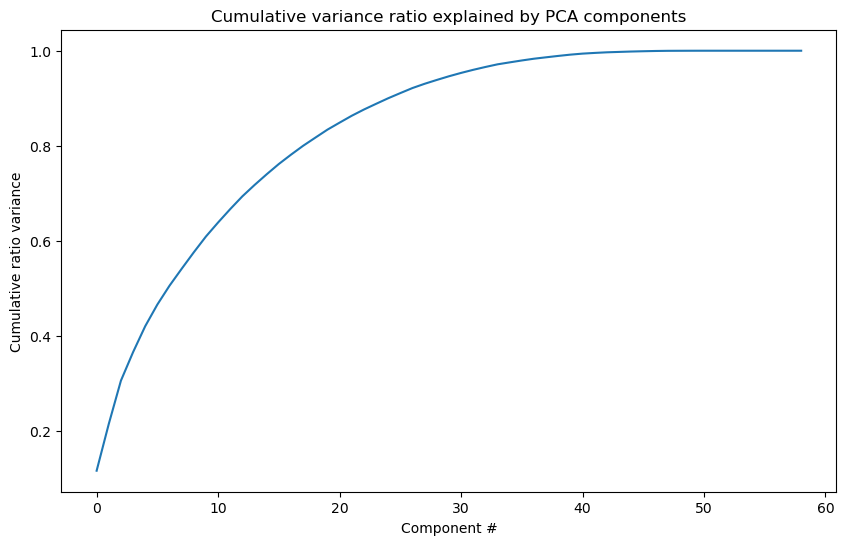

In [84]:

plt.subplots(figsize=(10, 6))
plt.plot(bridges_PCA.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components');


In [87]:
bridges_PCA_x = bridges_PCA.transform(bridge_df_scaled_n)

In [89]:
bridges_PCA_x.shape

(14622, 59)

In [107]:
pc_var = 100 * bridges_PCA.explained_variance_ratio_.cumsum()[15]

pc_var

76.18201205568998

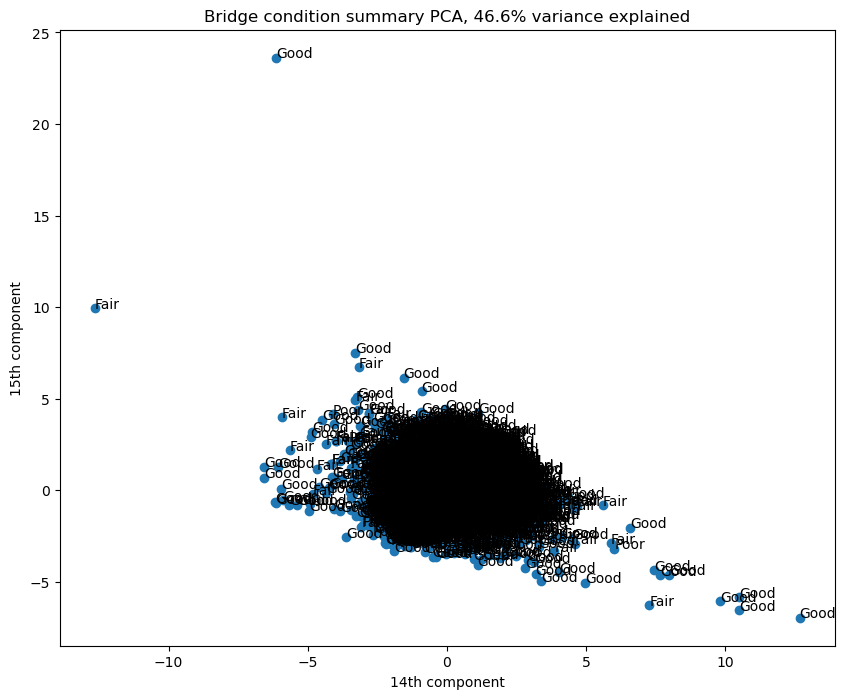

In [109]:
x = bridges_PCA_x[:, 14]
y = bridges_PCA_x[:, 15]
index = bridge_df_index
pc_var = 100 * bridges_PCA.explained_variance_ratio_.cumsum()[5]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('14th component')
plt.ylabel('15th component')

plt.title(f'Bridge condition summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(index, x, y):
    plt.annotate(s, (x, y))

In [85]:
# define useful function to create scatterplots of condition rate against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'condition_rate', data=n_bridges, alpha=0.5, )
        ax.set(xlabel=col, ylabel='Condition Rate')
        ax.set_xticklabels(ax.get_xticks(),rotation=45)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
features = [x for x in n_bridges.columns if x in ['structure_length[ft]',
                                                     'main_span_design',
                                                     'approach_desing',
                                                     'avg_daily_traffic',
                                                    'spans_units',
                                                    'avg_daily_truck_traffic',
                                                    'operating_rating[us-tons]']]        
        
#scatterplots(features, ncol=2, figsize=(10, 15))      

In [ ]:
#Function to impute NaN values for categorical columns

def _handling_category_for_nan_imputation(
    dataset: pd.DataFrame, nan_replace_value: Any
) -> pd.DataFrame:
    pd_categorical_columns = identify_columns_by_type(
        dataset, include=["category"]
    )
    if pd_categorical_columns:
        for col in pd_categorical_columns:
            if isinstance(nan_replace_value, pd.DataFrame):
                values_ = nan_replace_value[col].unique().tolist()
                values = [
                    x for x in values_ if x not in dataset[col].cat.categories
                ]
                dataset[col] = dataset[col].cat.add_categories(values)
            else:
                if isinstance(nan_replace_value, dict):
                    value = nan_replace_value[col]
                else:
                    value = nan_replace_value
                if not value in dataset[col].cat.categories:
                    dataset[col] = dataset[col].cat.add_categories(value)
    return dataset

In [33]:
def identify_columns_by_type(
    dataset, include):
    """
    Given a dataset, identify columns of the types requested.

    Parameters:
    -----------
    dataset : NumPy ndarray / Pandas DataFrame
    include : list of strings
        Desired column types

    Returns:
    --------
    A list of columns names

    Example:
    --------
    >>> df = pd.DataFrame({'col1': ['a', 'b', 'c', 'a'], 'col2': [3, 4, 2, 1], 'col3': [1., 2., 3., 4.]})
    >>> identify_columns_by_type(df, include=['int64', 'float64'])
    ['col2', 'col3']

    """
    df: pd.DataFrame = convert(dataset, "dataframe")  # type: ignore
    columns = list(df.select_dtypes(include=include).columns)
    return columns




In [32]:
#pd.options.mode.copy_on_write = True 

#cat_columns = identify_columns_by_type(n_bridges,'category')

#n_bridges_cat = n_bridges[cat_columns]

#n_bridges_cat_c = n_bridges_cat.dropna(how = 'any', axis=0, inplace=False)

#identify_columns_with_na(dataset = n_bridges_cat_c)


In [30]:
#%matplotlib notebook

#dython.nominal.associations(n_bridges_cat_c, nom_nom_assoc="theil", figsize=(15, 15))



#help(dython)
